# Aula 5 - KNN e ferramentas especiais

Na aula de hoje, vamos explorar os seguintes tópicos em Python:
- 0) Exercício da aula passada
- 1) KNN
- 2) Outros Scalers
- 3) KNN para regressão

____
____
____

## 1) KNN

Hoje conheceremos um novo algoritmo de aprendizagem (que inicialmente veremos no contexto de classificação): o KNN, que é a sigla de **k nearest neighbors**, ou seja, **k vizinhos mais próximos**.

A ideia é bem simples: tomamos uma base de treino classificada (supervisionada). 

A cada observação de teste que queiramos classificar, tomamos **a classe como sendo a classe das $k$ observações que estão mais próximas do elemento a ser classificado**

<img src="https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1531424125/KNN_final1_ibdm8a.png" width=600>

Este algoritmo é muito simples e intuitivo, mas há dois elementos de extrema importância:

> Como medir a **distância** entre dados? Qual é a **métrica** adequada?

Veremos que o sklearn nos permite escolher diferentes métricas de distância, o que é ótimo, pois assim podemos seguir a habitual abordagem: testar diferentes métricas, e escolher a que der melhores resultados!

> Qual é o número de vizinhos adequados: i.e., **como escolher $k$?**

Essa é uma escolha particularmente importante, pois escolhas diferentes de $k$ podem facilmente levar a classificações diferentes:

<img src="https://helloacm.com/wp-content/uploads/2016/03/2012-10-26-knn-concept.png" width=400>

Veremos logo como escolher bons valores!

> **Reflita e responda**: como a escolha de $k$ influencia a performance de generalização do modelo (isto é, seu comportamento no que diz respeito ao trade-off viés-variância)?
><br><br>Dica: pense no que acontece nos extremos, $k=1$ e $k=N$, ond $N$ é o número de observações na base de treino.

Conclusão: 

- $k=1$ temos alta variância (overfitting - pense nos outliers!).

- $k=N$ temos alto viés (underfitting - não aprendemos nada, só predizemos diretamente a classe majoritária na base de treino).

As etapas do algoritmo são as seguintes:

1. Recebe um dado não classificado;
2. Mede sua distância (Euclidiana, Manhattan, Minkowski ou Ponderada) de cada um dos elementos da base de treino;
3. Obtém um *ranking* das distâncias, em ordem decrescente;
4. Verifica a classe de cada da um dos *K* dados que tiveram a menor distância e conta a quantidade de cada classe;
5. Toma como resultado a classe que mais apareceu dentre os dados que tiveram as menores distâncias;
6. Classifica o novo dado com a classe tomada como resultado da classificação.

KNN é um método LAZY LEARNER -- Ou seja, **não há uma etapa explícita de treinamento**, conforme vimos antes.

Cada observação de teste é classificada por vez, segundo o passo a passo acima.

> **MUITO IMPORTANTE**: sempre devemos **escalar os dados** quando formos construir um modelo KNN! Reflita: por quê?

In [16]:
# importe as principais bibliotecas

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
from scipy.spatial import distance

x = np.random.rand(10)
y = np.random.random(10)

In [3]:
x

array([0.92836149, 0.46099157, 0.23748555, 0.62409823, 0.63584893,
       0.6328735 , 0.50626358, 0.29700229, 0.40354318, 0.67158072])

In [5]:
y

array([0.55053863, 0.82513742, 0.94788532, 0.85371362, 0.44573564,
       0.19626007, 0.33051521, 0.22000697, 0.69547233, 0.9618127 ])

In [4]:

distance.euclidean(x, y)

1.1250736556992194

#### Lendo conjunto de dados

Como exemplo vamos utilizar dados de câncer de mama (o dataset que foi sugerido como exercício!), eles estão disponiveis no [UCI](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) ou pelo [kaggle](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data). 

A ideia é que consigamos construir um modelo para classificar, com base em medidas fisiológicas, se um tumor é maligno ou benigno.

In [9]:
df = pd.read_csv("datasets/breast_cancer.csv")

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

Há um leve desbalanceamento: há mais dados de tumores benignos do que malignos. 

Como o desbalanceamento não é tão gritante assim (coisa de 80-20), e este desbalanço é algo natural, não vamos tratar este caso, vamos deixar para tratar um caso mais crítico.

[Clique aqui](https://machinelearningmastery.com/what-is-imbalanced-classification/) para saber um pouco mais sobre desbalanceamento de classes; e [aqui](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/) caso você queira saber algumas formas de endereçar este problema (spoilers!).

Uma coisa importante é sempre setar o parâmetro `stratify` do train-test split, que vai garantir a mesma distribuição do target em ambos os conjuntos de treino e de teste! Isso faz com que a diferença na distribuição não se torne um fator adicional de viés na avaliação do modelo!

In [12]:
df['diagnosis'].value_counts(normalize=True)

B    0.627417
M    0.372583
Name: diagnosis, dtype: float64

In [13]:
X = df.drop(columns=['id', 'diagnosis', 'Unnamed: 32'])
y = df['diagnosis']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75,
                                                   random_state=42, stratify = y)

In [17]:
y_train.value_counts(normalize=True)

B    0.626761
M    0.373239
Name: diagnosis, dtype: float64

In [18]:
y_test.value_counts(normalize=True)

B    0.629371
M    0.370629
Name: diagnosis, dtype: float64

_____

**Transformando os dados**

O primeiro processo que pode ser feito para tunning do KNN é a **transformação das features**. 

Devido ao KNN utilizar **distâncias** como critério para classificação, ter as variaveis transformadas garante que sejam eliminados viéses relacionados à escala dos dados.

Para **normalizar os dados**, o sklearn nos apresenta a ferramenta [standard scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

É **muito importante** que os transformers sejam fitados **com os dados de treino**, para que informações da base de teste não sejam utilizadas no treinamento (conceito conhecido como [data leakage](https://machinelearningmastery.com/data-preparation-without-data-leakage/)).

No caso do standard scaler: o objetivo do `.fit()` é determinar a média $\mu$ e desvio padrão $\sigma$ dos dados, para que a normalização seja feita. Se calcularmos estes parâmetros usando **todos os dados**, estamos utilizando informações da base de teste -- o que, como sabemos, jamais deve ser feito!!

Por isso, sempre siga o seguinte passo-a-passo par aplicação de transformers:

- Primeiro, faça o train test split;
- Use o `.fit()` nos dados de **treino**;
- Use o `.transform()` pra trasnformar os dados de treino e de teste tbm -- com o **mesmo transformer treinado** com os dados de treino;

Começaremos com o  [standard scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) - **média 0 e std 1**

In [19]:
X_train.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,...,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000
mean,14.167697,19.399671,92.192864,660.076056,0.095997,0.102962,0.088765,0.048934,0.181377,0.062628,...,16.366113,25.844437,107.900493,892.952817,0.132240,0.252615,0.273823,0.115279,0.290763,0.083864
std,3.581408,4.284875,24.666699,361.429125,0.014373,0.052897,0.081054,0.039332,0.027487,0.007056,...,4.929533,6.052785,34.314367,587.700855,0.023507,0.154457,0.208187,0.066066,0.063287,0.017873
min,6.981000,9.710000,43.790000,143.500000,0.062510,0.019380,0.000000,0.000000,0.106000,0.050240,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.710000,16.335000,75.222500,420.350000,0.085318,0.063732,0.029680,0.020280,0.162850,0.057443,...,13.010000,21.480000,84.100000,515.825000,0.115300,0.147725,0.120725,0.065035,0.251600,0.071318
50%,13.355000,18.945000,86.210000,548.750000,0.095450,0.092350,0.059640,0.033375,0.179550,0.061290,...,14.975000,25.470000,97.735000,684.550000,0.131150,0.216100,0.229800,0.101350,0.281350,0.080140
75%,15.977500,21.817500,104.600000,796.650000,0.104900,0.129350,0.132050,0.073580,0.194975,0.066195,...,19.187500,30.142500,126.850000,1123.250000,0.146650,0.330650,0.385900,0.161200,0.317475,0.091865
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [20]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [21]:
y_pred_no_scaler = model.predict(X_test)

In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [23]:
model_scaler = KNeighborsClassifier(n_neighbors=3)
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

In [25]:
pd.DataFrame(data=X_train_scaler[:10], columns=X_train.columns)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,-0.745750,-0.221894,-0.767638,-0.699925,-0.177450,-0.814845,-0.770582,-0.718931,0.073676,-0.466541,...,-0.689742,-0.559811,-0.723010,-0.654252,-0.593686,-0.957479,-0.927050,-0.755265,-0.265180,-1.064013
1,1.809320,-0.478913,1.729345,1.869571,-0.107095,0.087784,0.789726,1.030298,-0.884252,-1.113563,...,1.828667,-0.442372,1.718486,1.793915,1.020468,0.342793,0.683250,1.453604,-0.345860,-0.745834
2,-0.650703,-0.107404,-0.677127,-0.642862,-0.507630,-0.642799,-0.766753,-0.891003,-1.022660,-0.292015,...,-0.622720,-0.141330,-0.661739,-0.590539,-0.180565,-0.418832,-0.609415,-0.699346,-0.589483,-0.220391
3,-0.622749,-0.270961,-0.669009,-0.616269,-0.932545,-1.049540,-0.852846,-0.902203,0.197514,-0.216813,...,-0.663339,-0.746722,-0.706963,-0.623077,-0.759787,-1.060153,-0.874247,-0.792847,-0.193991,-0.548093
4,-0.468997,-0.595739,-0.527762,-0.494387,-0.758399,-1.223101,-1.041178,-1.082090,-2.180915,-0.836876,...,-0.614596,-1.014682,-0.683330,-0.594117,-0.930146,-1.316383,-1.223623,-1.325061,-1.567138,-1.239347
5,-0.597589,-0.343394,-0.653586,-0.593001,-1.335169,-1.212123,-1.077332,-1.103243,-1.572649,-0.273569,...,-0.669432,-0.594547,-0.734097,-0.629550,-1.317713,-1.158418,-1.279638,-1.323243,-1.165318,-0.755917
6,-0.041288,-0.873787,-0.105645,-0.148408,-1.138037,-0.892446,-0.838641,-0.570532,-0.818691,-0.960321,...,-0.295733,-1.080845,-0.331752,-0.347613,-1.228275,-0.978221,-1.015777,-0.501888,-1.220687,-0.939094
7,-1.022502,0.862258,-1.028620,-0.902692,0.383298,-0.662294,-0.788245,-0.768313,-0.432606,0.416020,...,-1.104061,-0.268694,-1.102889,-0.903310,-0.764045,-1.079080,-1.116862,-1.273386,-1.076728,-0.901563
8,-0.362769,0.032788,-0.386515,-0.417934,-0.323036,-0.456746,-0.874462,-0.713586,0.172018,0.119468,...,-0.389158,-0.242229,-0.372308,-0.453233,-0.461658,-0.566620,-0.974083,-0.779512,0.641287,-0.364916
9,0.875629,-0.541999,0.844523,0.742716,0.334538,0.021539,0.467338,0.880626,-0.002813,-0.922011,...,0.707569,-0.124789,0.671047,0.560547,0.398657,-0.078531,0.307665,1.067173,0.364443,-0.153171


In [31]:
### MINMAX SCALER
model_min_scaler = KNeighborsClassifier(n_neighbors=3)
scaler = MinMaxScaler()
X_train_min_scaler = scaler.fit_transform(X_train)
X_test_min_scaler = scaler.transform(X_test)

In [34]:
pd.DataFrame(data=X_train_min_scaler[:10], columns=X_train.columns)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0.213877,0.295570,0.203787,0.111941,0.306671,0.124318,0.061809,0.102833,0.390909,0.192797,...,0.179296,0.278252,0.162907,0.079557,0.311233,0.075298,0.064736,0.224880,0.231618,0.064476
1,0.646457,0.258370,0.628913,0.505408,0.316682,0.270597,0.357779,0.444384,0.258081,0.096186,...,0.620420,0.297175,0.579660,0.432757,0.561514,0.269921,0.332188,0.725773,0.221565,0.101732
2,0.229968,0.312141,0.219197,0.120679,0.259689,0.152199,0.062535,0.069235,0.238889,0.218856,...,0.191035,0.345682,0.173365,0.088749,0.375289,0.155922,0.117492,0.237560,0.191208,0.163256
3,0.234701,0.288468,0.220579,0.124751,0.199227,0.086283,0.046204,0.067048,0.408081,0.230085,...,0.183920,0.248134,0.165646,0.084054,0.285478,0.059930,0.073506,0.216357,0.240489,0.124885
4,0.260732,0.241461,0.244627,0.143415,0.224006,0.058156,0.010480,0.031923,0.078283,0.137500,...,0.192458,0.204957,0.169680,0.088232,0.259064,0.021577,0.015479,0.095670,0.069387,0.043946
5,0.238961,0.277984,0.223205,0.128314,0.141937,0.059935,0.003622,0.027793,0.162626,0.221610,...,0.182853,0.272655,0.161014,0.083120,0.198970,0.045221,0.006176,0.096082,0.119456,0.100551
6,0.333144,0.201217,0.316495,0.196394,0.169987,0.111742,0.048899,0.131809,0.267172,0.119068,...,0.248310,0.194296,0.229693,0.123796,0.212838,0.072193,0.050000,0.282337,0.112557,0.079103
7,0.167022,0.452486,0.159353,0.080891,0.386461,0.149040,0.058458,0.093191,0.320707,0.324576,...,0.106724,0.325160,0.098063,0.043625,0.284818,0.057097,0.033211,0.107388,0.130495,0.083497
8,0.278716,0.332432,0.268675,0.155122,0.285955,0.182351,0.042104,0.103877,0.404545,0.280297,...,0.231946,0.329424,0.222770,0.108558,0.331704,0.133801,0.056925,0.219381,0.344569,0.146333
9,0.488381,0.249239,0.478267,0.332853,0.379522,0.259861,0.296626,0.415159,0.380303,0.124788,...,0.424048,0.348348,0.400867,0.254817,0.465099,0.206857,0.269808,0.638144,0.310073,0.171127


In [26]:
model_scaler.fit(X_train_scaler, y_train)
y_pred_scaler = model_scaler.predict(X_test_scaler)

In [32]:
model_min_scaler.fit(X_train_min_scaler, y_train)
y_pred_min_scaler = model_min_scaler.predict(X_test_min_scaler)

In [27]:
print(classification_report(y_test, y_pred_no_scaler))

              precision    recall  f1-score   support

           B       0.90      1.00      0.95        90
           M       1.00      0.81      0.90        53

    accuracy                           0.93       143
   macro avg       0.95      0.91      0.92       143
weighted avg       0.94      0.93      0.93       143



In [28]:
print(classification_report(y_test, y_pred_scaler))

              precision    recall  f1-score   support

           B       0.94      1.00      0.97        90
           M       1.00      0.89      0.94        53

    accuracy                           0.96       143
   macro avg       0.97      0.94      0.95       143
weighted avg       0.96      0.96      0.96       143



In [33]:
print(classification_report(y_test, y_pred_min_scaler))

              precision    recall  f1-score   support

           B       0.96      1.00      0.98        90
           M       1.00      0.92      0.96        53

    accuracy                           0.97       143
   macro avg       0.98      0.96      0.97       143
weighted avg       0.97      0.97      0.97       143



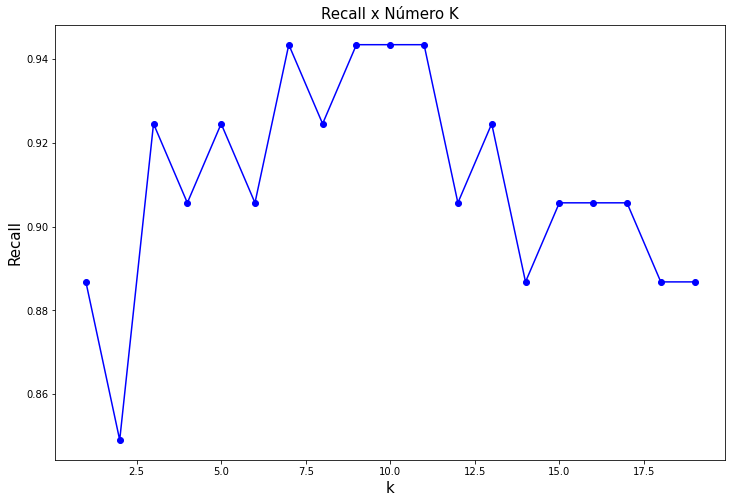

Melhor k: 7


In [35]:
from sklearn.metrics import recall_score

ks = []
recalls = []
for k in range(1, 20):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_min_scaler, y_train)
    y_pred = model.predict(X_test_min_scaler)
    rec = recall_score(y_test, y_pred, pos_label='M')
    recalls.append(rec)
    ks.append(k)
    
plt.figure(figsize=(12,8))
plt.plot(ks, recalls, '-bo')
plt.xlabel('k', fontsize = 15)
plt.ylabel('Recall', fontsize = 15)
plt.title('Recall x Número K', fontsize = 15)
plt.show(True)
best_k = np.argmax(recalls)+1
print('Melhor k:', best_k)

### Exercício

Vamos fazer a predição do dataset de [diabetes]() e comparar os resultados do KNN com os da Regressão Logística

#### Passo a passo para fazer uma predição

1 - Instancie o Standard Scaler

2 - Escolha o estimador (Aqui voce deve fazer um experimento com cada um deles)

3 - Faça o fit transform dos dados de treino e o transform dos dados de teste

4 - Faça o fit com os dados escalados (Não escale o target!!!)

5 - Gere a predição com os dados de teste escalados

6 - Analise as metricas usando matriz de confusão e classification report (compare os 2 modelos e veja a que conclusões podemos chegar!)

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# Carregar
data = pd.read_csv('./diabetes_prediction_dataset.csv')

In [5]:
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [11]:
X, y = data.drop(columns=['diabetes','gender','smoking_history']), data['diabetes']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=42)

In [18]:
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

In [30]:
scaler.fit(X_train, y_train)
y_pred_scaler = scaler.predict(X_test)

AttributeError: 'StandardScaler' object has no attribute 'predict'

In [19]:
### MINMAX SCALER
model_min_scaler = KNeighborsClassifier(n_neighbors=3)
scaler_min = MinMaxScaler()
X_train_min_scaler = scaler_min.fit_transform(X_train)
X_test_min_scaler = scaler_min.transform(X_test)

In [24]:
model_min_scaler.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [25]:
y_pred = model_min_scaler.predict(X_test)

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     18292
           1       0.82      0.57      0.67      1708

    accuracy                           0.95     20000
   macro avg       0.89      0.78      0.82     20000
weighted avg       0.95      0.95      0.95     20000



## 2) Outros Scalers

Outra opção é transformar os dados com o [min max scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) - **deixa o espaço amostral entre 0 e 1**

Aqui, as mesmas considerações sobre o método `.fit()` são válidas! (E pra qualquer outro transformer)

In [116]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler().fit(X_train)

X_train_mms = mms.transform(X_train)
X_test_mms = mms.transform(X_test)

## Comparação

Podemos testar também o [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html):

Agora sim, estamos prontos para treinar e avaliar o modelo, com as features escaladas!

Classe: [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

## 3) KNN para regressão

O KNN é nosso primeiro exemplo de algoritmo que pode ser utilizado para ambos os problemas de classificação e regressão!

A ideia é bem simples: o target atribuído a uma nova observação é igual à **média do target das $k$ observações mais próximas**

<img src="https://bookdown.org/f100441618/bookdown-regresion/www/KNN.jpg" width=500>

A classe no sklearn é a [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html). Dê uma olhada no User Guide e também no [RadiusNeighborsRegressor!](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsRegressor.html#sklearn.neighbors.RadiusNeighborsRegressor)

In [114]:
from sklearn.neighbors import KNeighborsRegressor